## Data Loading, Cleaning, and Basic Summary

First, we load the Excel file into a DataFrame and remove empty rows if any (precautionary step although the dataset looks clean already).

After cleaning, we check some quick statistics:

- Number of rows and columns
- Years covered
- Unique constituencies, districts, candidates, and parties
- Missing values count


In [1]:
!pip install openpyxl --quiet
!pip install python-louvain --quiet

In [2]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
uploaded = files.upload()

Saving Elections Analysis (2.0).xlsx to Elections Analysis (2.0).xlsx


In [4]:
file_name = list(uploaded.keys())[0]
df_raw = pd.read_excel(io.BytesIO(uploaded[file_name]), sheet_name='Data', header=None)
header_row_index = df_raw[df_raw.iloc[:,0].astype(str).str.contains("Assembly", case=False, na=False)].index[0]
df = pd.read_excel(
    io.BytesIO(uploaded[file_name]),
    sheet_name='Data',
    keep_default_na=False,
    na_values=[''],
    skiprows=header_row_index
)
intended_cols = [
    'Assembly', 'Assembly Constituency', 'Agency/ District', 'Year', 'Candidate ',
    'Platform', 'Bureaucratic Connections', 'Family in Politics (Previous)',
    'Social/ Tribal/ Hereditary', 'Religious Affiliations (Scale)',
    'Religious Affiliations (Party/ Sect)', 'Financial Transactions',
    'Conditional Electoral Deposits', 'Economic Wealth', 'Military Influence'
]
df = df.iloc[:, :len(intended_cols)]
df.columns = intended_cols
df = df.dropna(how='all').reset_index(drop=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(df)

   Assembly          Assembly Constituency  Agency/ District  Year  \
0        NA               NA-43 Bajuar - I            Bajaur  2002   
1        NA              NA-44 Bajuar - II            Bajaur  2002   
2        NA              NA-36 Mohmand - I           Mohmand  2002   
3        NA               NA-45 Khyber - I            Khyber  2002   
4        NA              NA-46 Khyber - II            Khyber  2002   
5        NA               NA-37 Kurram - I            Kurram  2002   
6        NA              NA-38 Kurram - II            Kurram  2002   
7        NA                  NA-39 Orakzai           Orakzai  2002   
8        NA         NA-40 North Waziristan  North Waziristan  2002   
9        NA     NA-41 South Waziristan - I  South Waziristan  2002   
10       NA    NA-42 South Waziristan - II  South Waziristan  2002   
11       NA              NA-47 FR Peshawar  Frontier Regions  2002   
12       NA               NA-43 Bajuar - I            Bajaur  2008   
13       NA         

In [8]:
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
print("Years covered:", df['Year'].unique())
print("Unique Constituencies:", df['Assembly Constituency'].nunique())
print("Unique districts:", df['Agency/ District'].nunique())
print("Unique candidates:", df['Candidate '].nunique())
print("Unique Parties:", df['Platform'].nunique())
df.isnull().sum()

Number of rows: 86
Number of columns: 15
Years covered: [2002 2008 2013 2018 2019 2024]
Unique Constituencies: 64
Unique districts: 11
Unique candidates: 66
Unique Parties: 11


,0
Assembly,0
Assembly Constituency,0
Agency/ District,0
Year,0
Candidate,0
Platform,4
Bureaucratic Connections,4
Family in Politics (Previous),4
Social/ Tribal/ Hereditary,4
Religious Affiliations (Scale),4


## Exploratory Data Analysis

# 1. Candidate Profile Composition

We look at what percentage of candidates:

- Have family in politics
- Have strong bureaucratic connections
- Have strong military influence


In [20]:
profile_counts = {
    "With Family in Politics (%)": (df['Family in Politics (Previous)'] == "Yes").mean()*100,
    "With High/Very High Bureaucratic Links (%)": df['Bureaucratic Connections'].isin(["High", "Very High"]).mean()*100,
    "With High/Very High Military Influence (%)": df['Military Influence'].isin(["High", "Very High"]).mean()*100
}
profile_df = pd.DataFrame(list(profile_counts.items()), columns=["Metric", "Value (%)"])
print("Candidate Profile Overview:")
print(profile_df, "\n")

Candidate Profile Overview:
                                       Metric  Value (%)
0                 With Family in Politics (%)  50.000000
1  With High/Very High Bureaucratic Links (%)  58.139535
2  With High/Very High Military Influence (%)  33.720930 



**Findings:**
- About half have family in politics; politics is still very dynastic.
- Around 60% have strong bureaucratic connections; admin links matter a lot.
- Around 1/3 have strong military links; less common than family or bureaucracy.

Thus, getting into politics often depends on having elite networks, especially bureaucratic ones.



# 2. Trait Trends Over Time

We check how these traits change over the years.

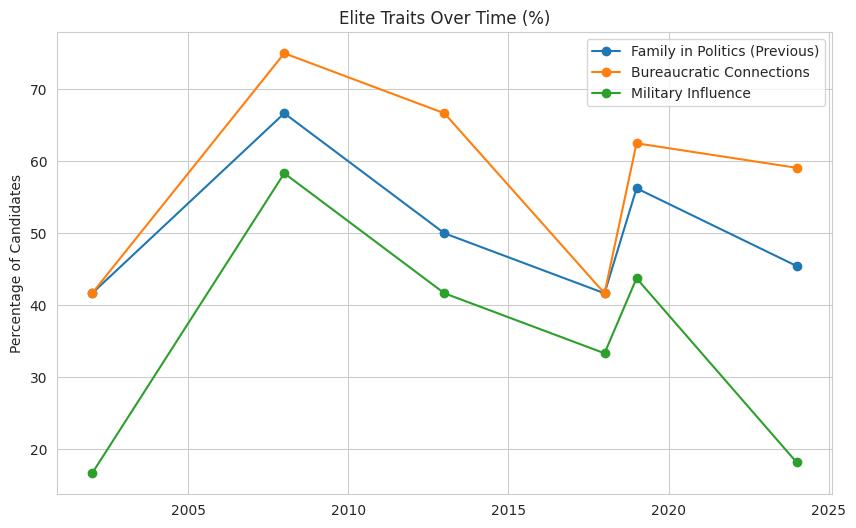

In [19]:
yearly_traits = df.groupby('Year').agg({
    'Family in Politics (Previous)': lambda x: (x == "Yes").mean()*100,
    'Bureaucratic Connections': lambda x: x.isin(["High", "Very High"]).mean()*100,
    'Military Influence': lambda x: x.isin(["High", "Very High"]).mean()*100
}).reset_index()
plt.figure(figsize=(10,6))
for col in yearly_traits.columns[1:]:
    plt.plot(yearly_traits['Year'], yearly_traits[col], marker='o', label=col)
plt.title("Elite Traits Over Time (%)")
plt.ylabel("Percentage of Candidates")
plt.legend()
plt.show()

**Findings:**

- Bureaucratic connections have always been the most common, but fell from aprox. 75% in 2008 to aprox. 59% in 2023.
- Family links dipped in the mid-2010s, then bounced back around 2018–2019.
- Military influence peaked in 2008, then dropped, with a short revival around 2018–2019.

Notably, 2008 was the “peak” year for elite traits, then the field became a bit more mixed.



# 3. Intersection: Military Influence vs Economic Wealth

We compare wealth categories for candidates with different military influence levels.

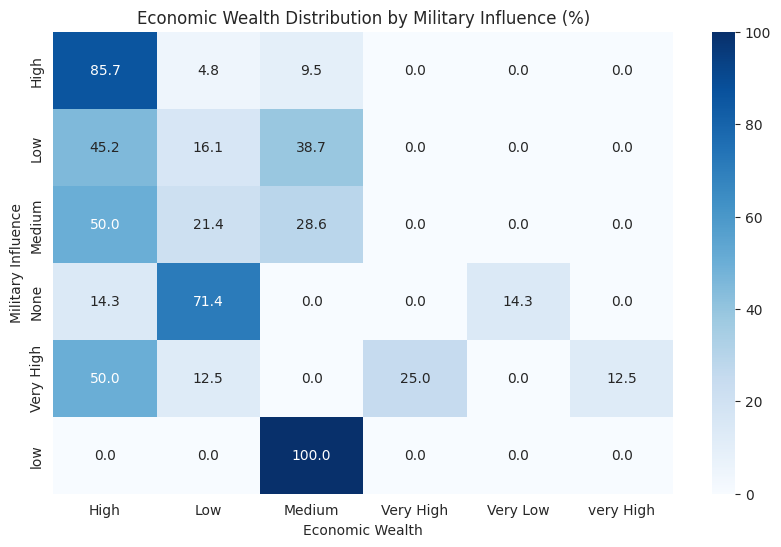

In [17]:
military_vs_wealth = pd.crosstab(df['Military Influence'], df['Economic Wealth'], normalize='index')*100
plt.figure(figsize=(10,6))
sns.heatmap(military_vs_wealth, annot=True, fmt=".1f", cmap="Blues")
plt.title("Economic Wealth Distribution by Military Influence (%)")
plt.show()

**Findings:**
- High military influence; mostly high-wealth candidates (85%+).
- No military influence; mostly low-wealth (71%).
- Very high military influence; still mostly higher wealth.

Thus, military power often goes with high wealth.





# 4. Districts with Highest 'Elite Capture'

We define “Elite Capture” as having any one of these:
- Family in politics
- High bureaucratic links
- High military influence

In [16]:
df['Elite Capture']=(
    (df['Family in Politics (Previous)'] == "Yes") |
    df['Bureaucratic Connections'].isin(["High", "Very High"]) |
    df['Military Influence'].isin(["High", "Very High"])
)
elite_by_district = df.groupby('Agency/ District')['Elite Capture'].mean().sort_values(ascending=False)*100
print("Top Districts by Elite Capture (% of candidates):")
print(elite_by_district.head(5),"\n")

Top Districts by Elite Capture (% of candidates):
Agency/ District
Orakzai             100.000000
Orakzai             100.000000
Frontier Regions     80.000000
Kurram               75.000000
Bajaur               66.666667
Name: Elite Capture, dtype: float64 



**Findings:**
- Some districts like Orakzai have 100% elite candidates.
- This means no ordinary person contests there, i.e. it’s all elites.

That is to say, in some areas, politics is fully controlled by elites.




# 5. Party Power Concentration

We check which parties have the most candidates.

In [15]:
party_counts = df['Platform'].value_counts(normalize=True)*100
print("Party Representation (% of candidates):")
print(party_counts.head(5),"\n")

Party Representation (% of candidates):
Platform
IND       43.902439
PTI       32.926829
JUIF       9.756098
PML(N)     2.439024
PPP        2.439024
Name: proportion, dtype: float64 



**Findings**

- Independents lead (43.9%), then PTI (32.9%).
- Older parties like PML-N and PPP have very few candidates (less than 3%).
- High independent share might mean weak party systems or elites preferring to run solo.

Thus, personal influence matters more than party loyalty.


# 6. Religious Affiliation Trends

We look at how religious party/sect links change over time.

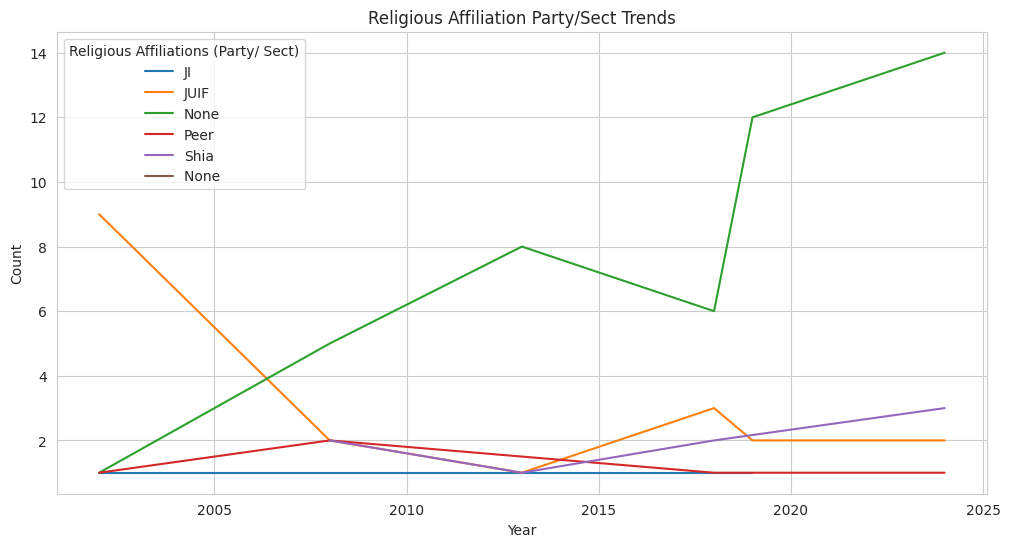

In [14]:
religion_trends = df.groupby(['Year', 'Religious Affiliations (Party/ Sect)']).size().reset_index(name='Count')
plt.figure(figsize=(12,6))
sns.lineplot(data=religion_trends, x='Year', y='Count', hue='Religious Affiliations (Party/ Sect)')
plt.title("Religious Affiliation Party/Sect Trends")
plt.show()

**Findings:**
- “None” is growing — fewer candidates link themselves to religious groups.
- JI and JUIF are shrinking over time.
- Small sectarian groups remain tiny in numbers.

Clearly, religion is becoming less central to candidate identity.

## Network Graph of Party Interconnections by Candidate Overlap and Influence

In [25]:
import networkx as nx
import matplotlib.colors as mcolors

We build a network where:

- Node size = number of candidates in a party
- Edge width = number of candidates shared between two parties
- Node color = % of candidates with high bureaucratic links

In [37]:
P = nx.Graph()
party_attributes = {}
for party in df['Platform'].unique():
    subset = df[df['Platform'] == party]
    attr = {
        'pct_family': (subset['Family in Politics (Previous)'] == "Yes").mean(),
        'pct_bureau': subset['Bureaucratic Connections'].isin(["High", "Very High"]).mean(),
        'pct_military': subset['Military Influence'].isin(["High", "Very High"]).mean(),
        'num_candidates': len(subset)
    }
    party_attributes[party] = attr

for party, attributes in party_attributes.items():
    P.add_node(party, **attributes)

candidates = df.groupby('Candidate ')['Platform'].unique()
for candidate, parties in candidates.items():
    parties = [p for p in parties if pd.notna(p)]
    if len(parties) > 1:
        for i in range(len(parties)):
            for j in range(i + 1, len(parties)):
                party1 = parties[i]
                party2 = parties[j]
                if P.has_edge(party1, party2):
                    P[party1][party2]['weight'] += 1
                else:
                    P.add_edge(party1, party2, weight=1)

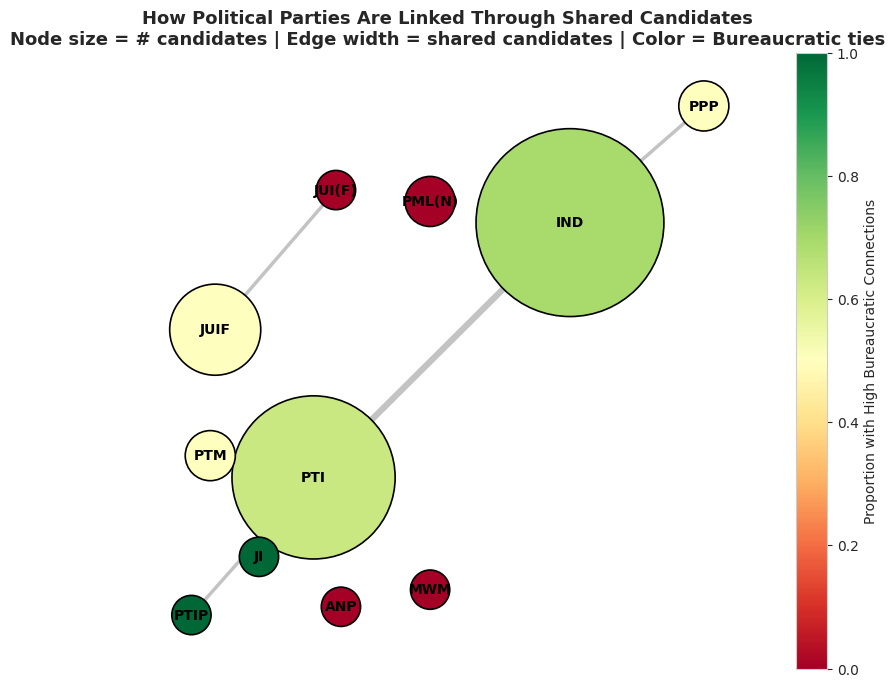

In [41]:
cmap = plt.cm.RdYlGn
pos = nx.kamada_kawai_layout(P)

node_sizes = [300 + 500*P.nodes[n]['num_candidates'] for n in P.nodes()]
node_colors = [P.nodes[n]['pct_bureau'] for n in P.nodes()]
edge_widths = [0.5 + 2*P[u][v]['weight'] for u, v in P.edges()]

fig, ax = plt.subplots(figsize=(10, 8))
nx.draw_networkx_edges(P, pos, width=edge_widths, alpha=0.5, edge_color="#888888")
nx.draw_networkx_nodes(
    P, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=cmap,
    edgecolors="black",
    linewidths=1.2
)
nx.draw_networkx_labels(P, pos, font_size=10, font_weight='bold')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Proportion with High Bureaucratic Connections')
ax.set_title("How Political Parties Are Linked Through Shared Candidates\n" "Node size = # candidates | Edge width = shared candidates | Color = Bureaucratic ties", fontsize=13, weight='bold')
ax.axis('off')
plt.show()

**Findings:**

- IND and PTI are at the center — they have the most candidates and share a lot with others.
- IND–PTI and PPP–IND connections are the strongest.
- Smaller parties (JUIF, ANP, etc.) are on the edges with few links.
- Even some small parties (PTIP, JI) have high bureaucratic ties.

The political “center” is therefore around IND and PTI, with most candidate flow and elite connections there.